In [6]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import ipympl 

In [7]:
def Mand(z0, max_steps):
    z = 0j  # no need to specify type.  
    # To initialize to complex number, just assign 0j==i*0
    for itr in range(max_steps):
        if abs(z)>2:
            return itr
        z = z*z + z0
    return max_steps

def Mandelbrot(ext, Nxy, max_steps):
    """
    ext[4]    -- array of 4 values [min_x,max_x,min_y,max_y]
    Nxy       -- int number of points in x and y direction
    max_steps -- how many steps we will try at most before we conclude the point is in the set
    """
    data = np.zeros((Nxy,Nxy)) # initialize a 2D dynamic array
    for i in range(Nxy):
        for j in range(Nxy):
            x = ext[0] + (ext[1]-ext[0])*i/(Nxy-1.)
            y = ext[2] + (ext[3]-ext[2])*j/(Nxy-1.)
            # creating complex number of the fly
            data[i,j] = Mand(x + y*1j, max_steps)  
    return data

In [8]:
data = Mandelbrot([-2,1,-1,1], 500, 1000)

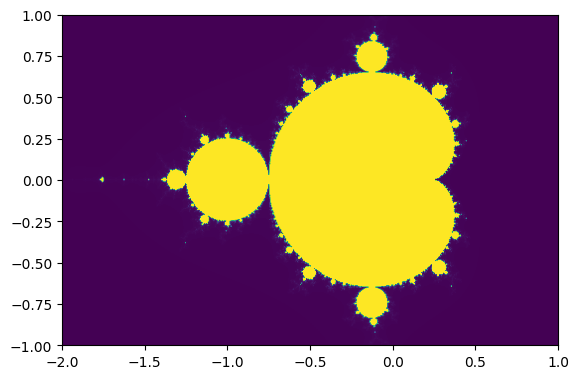

In [9]:
%matplotlib inline
ext=[-2,1,-1,1]
# pylab's function for displaying 2D image

plt.imshow(data.T,origin='lower',extent=ext)

In [10]:
import time            # timeing
t0 = time.time()
data = Mandelbrot([-2,1,-1,1], 1000, 1000)
t1 = time.time()
print ('clock time: ',t1-t0,'s')

clock time:  68.0781843662262 s


In [11]:
from numpy import * # because arrays are defined in numpy
from numba import njit  # This is the new line with numba

@njit   # this is an alias for @jit(nopython=True)
def Mand(z0, max_steps):
    z = 0j  # no need to specify type. 
    # To initialize to complex number, just assign 0j==i*0
    for itr in range(max_steps):
        if abs(z)>2:
            return itr
        z = z*z + z0
    return max_steps

@njit
def Mandelbrot2(ext, Nxy, max_steps):
    """
    ext[4]    -- array of 4 values [min_x,max_x,min_y,max_y]
    Nxy       -- int number of points in x and y direction
    max_steps -- how many steps we will try at most before we conclude the point is in the set
    """
    data = zeros((Nxy,Nxy)) # initialize a 2D dynamic array
    for i in range(Nxy):
        for j in range(Nxy):
            x = ext[0] + (ext[1]-ext[0])*i/(Nxy-1.)
            y = ext[2] + (ext[3]-ext[2])*j/(Nxy-1.)
            # creating complex number of the fly
            data[i,j] = Mand(x + y*1j, max_steps)  
    return data

In [12]:
import time            # timeing
t0 = time.time()
data = Mandelbrot2(array([-2,1,-1,1]), 1000, 1000)
t1 = time.time()
print ('clock time: ',t1-t0,'s')

clock time:  5.544275760650635 s


In [13]:
from numpy import * # because arrays are defined in numpy
from numba import njit  # This is the new line with numba
from numba import prange

@njit   # this is an alias for @jit(nopython=True)
def Mand(z0, max_steps):
    z = 0j  # no need to specify type. 
    # To initialize to complex number, just assign 0j==i*0
    for itr in range(max_steps):
        if abs(z)>2:
            return itr
        z = z*z + z0
    return max_steps

@njit(parallel=True)
def Mandelbrot3(data, ext, max_steps):
    """
    ext[4]    -- array of 4 values [min_x,max_x,min_y,max_y]
    Nxy       -- int number of points in x and y direction
    max_steps -- how many steps we will try at most before we conclude the point is in the set
    """
    Nx,Ny = shape(data) # 2D array should be already allocated we get its size
    for i in range(Nx):
        for j in prange(Ny):    # note that we used prange instead of range.
                                # this switches off parallelization of this loop, so that
                                # only the outside loop over i is parallelized.
            x = ext[0] + (ext[1]-ext[0])*i/(Nx-1.)
            y = ext[2] + (ext[3]-ext[2])*j/(Ny-1.)
            # creating complex number of the fly
            data[i,j] = Mand(x + y*1j, max_steps)  
# data now contains integers. 
# MandelbrotSet has value 1000, and points not in the set have value <1000.

In [14]:
import time            # timeing
data = zeros((1000,1000))
t0 = time.time()
Mandelbrot3(data, array([-2,1,-1,1]), 1000)
t1 = time.time()
print ('clock time: ',t1-t0,'s')    

clock time:  2.0618081092834473 s


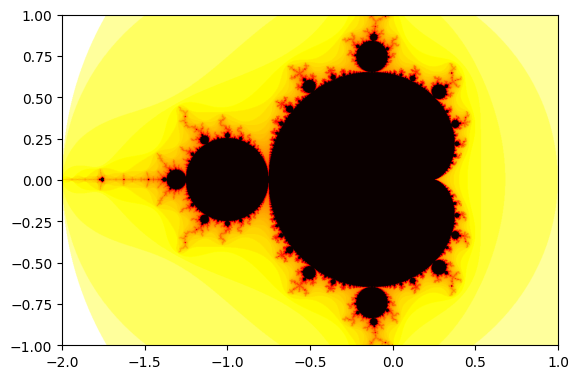

In [15]:
import matplotlib.cm as cm

plt.imshow(-log(data.T), extent=[-2,1,-1,1], cmap=cm.hot, origin='lower'); 

In [1]:
%%file mandc.cc

#include <iostream> // for printing to stdout
#include <complex>  // for complex numbers
#include <ctime>    // for measuring time
#include <vector>   // for using array/vector
#include <omp.h>    // openMP and measuing time with openMP
using namespace std;// everything from standard template library is available withouth prefix std
// std::cout and std::endl can be called cout, endl, etc...

int Mandelb(const complex<double>& z0, int max_steps)
{
  complex<double> z=0; // specify type where we start using it. (still need to specify type not like python with auto-typing)
  for (int i=0; i<max_steps; i++){ // specify int type inside the loop, so it is local to the loop. useful for reducing bugs.
    if (abs(z)>2.) return i;
    z = z*z + z0;
  }
  return max_steps;
}

int main()
{
  const int Nx = 1000; // constants are named cost rather than parameter
  const int Ny = 1000;
  int max_steps = 1000; // allowed to change later.
  double ext[]={-2,1,-1,1}; // this specifies fixed array of four numbers and initializes it.

  //double mand[Nx][Ny];
  
  vector<int> mand(Nx*Ny);  // allocating one dimensional array (vector) of size Nx*Ny
  // multidimensional dynamic arrays are not standard in C++. One can use pointers to allocate/deallocate memory,
  // and write one's own class interface for that. Or one has to use extension of C++ (blitz++ is excellent).
  // Unfortunately the standard C++ still does not support standard class for that.
  clock_t startTimec = clock();  // cpu time at the start 
  double start = omp_get_wtime(); // wall time at the start

  #pragma omp parallel for
  for (int i=0; i<Nx; i++){
    for (int j=0; j<Ny; j++){
      double x = ext[0] + (ext[1]-ext[0])*i/(Nx-1.); // x in the interval ext[0]...ext[1]
      double y = ext[2] + (ext[3]-ext[2])*j/(Ny-1.); // y in the interval ext[2]...ext[3]
      mand[i*Ny+j] = Mandelb(complex<double>(x,y), max_steps); // storing values in 2D array using 1D array
      //mand[i*Ny+j] = Mandelb(x+y*complex<double>(0.,1.), max_steps); // storing values in 2D array using 1D array
    }
  }

  clock_t endTimec = clock();
  double diffc = double(endTimec-startTimec)/CLOCKS_PER_SEC; // how to get seconds from cpu time
  double diff = omp_get_wtime()-start;                       // openMP time is already in seconds
  
  clog<<"clock time : "<<diffc<<"s"<<" with wall time="<<diff<<"s "<<endl; // printout of time
  for (int i=0; i<Nx; i++){
    for (int j=0; j<Ny; j++){
      double x = ext[0] + (ext[1]-ext[0])*i/(Nx-1.);
      double y = ext[2] + (ext[3]-ext[2])*j/(Ny-1.);
      cout<<x<<" "<<y<<" "<< 1./mand[i*Ny+j] << endl; // prinout of mandelbrot set
    }
  }
}

Overwriting mandc.cc


In [3]:
!{ls -l mandc.cc}

'{ls' is not recognized as an internal or external command,
operable program or batch file.
